In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

import nlbayes
from nlbayes.utils import gen_network, gen_evidence

In [2]:
net = network = gen_network(
        NX=125,      # total number of transcription factors
        NY=2500,     # total number of target genes
        AvgNTF=5,   # number of TFs that regulate a gene (average)
)

In [3]:
# randomly select 5 TFs as active
candidates = list(network.keys())
active_tfs = np.random.choice(candidates, size=5, replace=False)
active_tfs

array(['TF001', 'TF054', 'TF043', 'TF114', 'TF039'], dtype='<U5')

In [4]:
evd = evidence = gen_evidence(
        network=network,
        active_tfs=active_tfs,  # known set of active TFs. TFs with small regulon may not appear as active.
        tf_target_fraction=0.2, # only a fraction of a TF's targets will become diff. expr.
)

ngtac=5, ndegs=224, nrels=13796


In [5]:
model = nlbayes.ModelORNOR(network, evidence, uniform_t = False, n_graphs=5)
model.sample_posterior(N=2000, gr_level=1.1, burnin=True)


Initializing model burn-in ...



100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Converged after 20 samples
Max Gelman-Rubin statistic is 1.79866709466345 (target was 5.0 )
Burn-in complete ...



100%|██████████| 190/190 [00:21<00:00,  8.95it/s]

Converged after 190 samples
Max Gelman-Rubin statistic is 1.0912761675080134 (target was 1.1 )


In [6]:
df = model.inference_posterior_df()

df['gt_act'] = df['TF_id'].isin(active_tfs)     # ground truth for active TFs
f = lambda src: len(network[src])
df['tot_trgs'] = df.TF_id.apply(f)              # total number of targets for each TF
f = lambda src: sum([evd.get(k, 0) != 0 for k in net[src].keys()])
df['dif_trgs'] = df.TF_id.apply(f)              # number of targets that are diff. expr.

df = df.iloc[:, [0, 4, 5, 3, 1, 2]]
df.sort_values(['gt_act', 'X'], ascending=False).head(15) # show active TFs first

,TF_id,tot_trgs,dif_trgs,gt_act,X,T
rank,,,,,,
1,TF001,544,125,True,1.000000,0.972307
2,TF054,117,29,True,1.000000,0.863586
3,TF043,129,28,True,1.000000,0.887114
4,TF039,132,33,True,1.000000,0.904593
5,TF114,23,6,True,0.634211,0.645383
6,TF058,112,11,False,0.540789,0.606001
7,TF037,134,15,False,0.188158,0.560430
8,TF125,8,1,False,0.072368,0.514661
9,TF123,15,4,False,0.032895,0.498352


In [7]:
def plot_metric(method_name):
    curve = getattr(metrics, method_name)(df.gt_act, df.X)

    if method_name == 'roc_curve':
        x, y = curve[:2]
        plt.plot((0,1), (0,1), c='gray', linestyle='--')
    if method_name == 'precision_recall_curve':
        y, x = curve[:2]
        plt.plot((0,1), (1,0), c='gray', linestyle='--')
    
    auc = metrics.auc(x, y)
    plt.plot(x, y)
    plt.xlim(-.05,1.05)
    plt.ylim(-.05,1.05)
    plt.gca().set_aspect('equal')
    plt.grid(visible=True, which='major', color='lightgray', linestyle='-')
    plt.title(' '.join(method_name.split('_')) + f', {auc = :.4f}')
    plt.show()


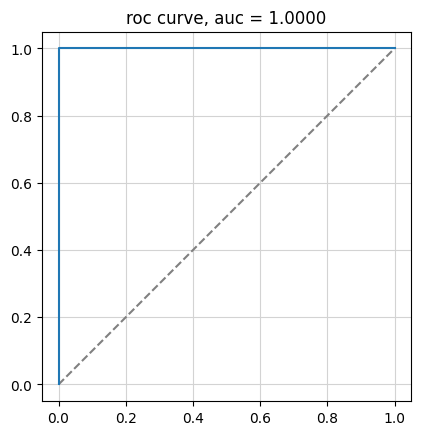

In [8]:
plot_metric('roc_curve')

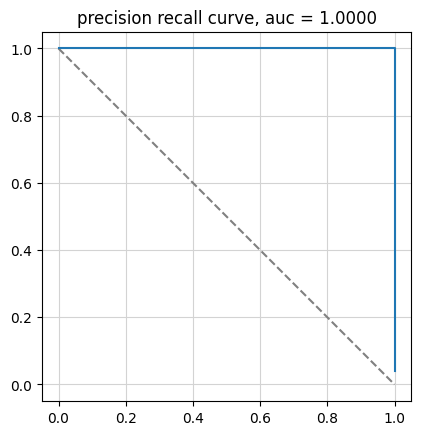

In [9]:
plot_metric('precision_recall_curve')